In [1]:
import sys
sys.path.append('../src')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import dataloader

%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

VOL = '/s/chopin/l/grad/stock/mlai2es/data/conus3/preprocessed'

In [1]:
import torch

In [2]:
# f = '../ckpt/vit_model_best.pth.tar'
f = '../ckpt/finetune01_finetune_vit_model_best.pth.tar'
ckpt = torch.load(f, map_location=torch.device('cpu'))

In [12]:
# Gremlin Data
import argparse
args = argparse.Namespace()
args.test = True
args.data_name = 'gremlin'
args.data_dir = '/s/chopin/l/grad/stock/mlai2es/data/conus3/preprocessed'
args.distributed = False
args.batch_size = 1
args.workers = 4
args.seed = 0

_, _, val_loader, _ = dataloader.get_dataset(args)

In [30]:
# x, t = val_loader.dataset.__getitem__(s)

T = []
for x, t in val_loader:
    T.append(t)
T = np.vstack(T)
Y = np.load(os.path.join(VOL, 'out', 'vit', 'test_predictions.npy'))

T.shape, Y.shape

(96, 1, 768, 1536)

In [50]:
rmse = lambda t, y: np.sqrt(np.mean((y - t)**2))

rmse: 0.06617


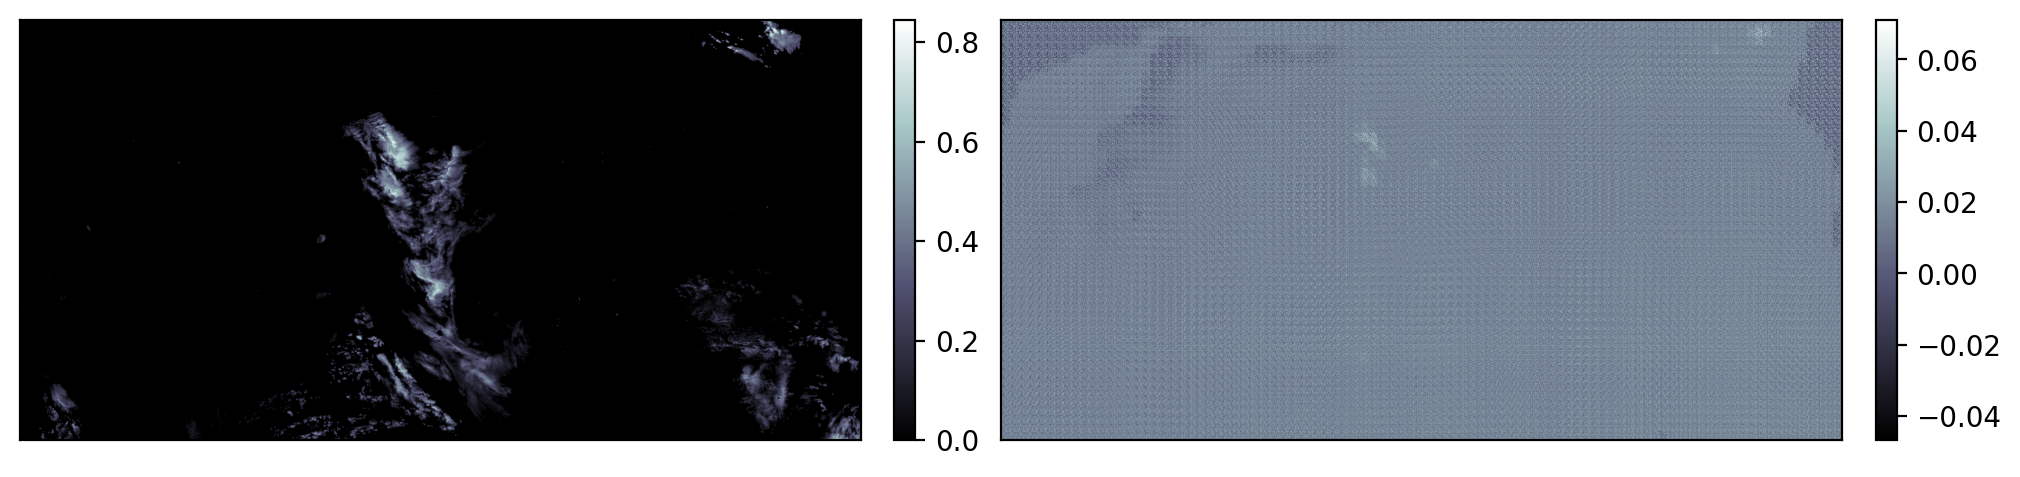

In [56]:
s = -1

y = Y[s, 0, ...]
t = T[s, 0, ...]
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
imt = axs[0].imshow(t, cmap='bone') #vmin=t.min(), vmax=t.max()
imy = axs[1].imshow(y, cmap='bone')
fig.colorbar(imt, ax=axs[0], fraction=0.025, pad=0.04)
fig.colorbar(imy, ax=axs[1], fraction=0.025, pad=0.04)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

print(f'rmse: {rmse(y, t):.5f}')

In [2]:
samples = []
with open(os.path.join(VOL, 'good_samples.txt'), 'r') as f:
    for l in f:
        # NOTE: test for full dataset
        if '2019/001' not in l:
            continue
        l = l.rstrip().rpartition('/')
        samples.append(l)

In [3]:
def read_data(filename):
    nlon = 1799
    nlat = 1059
    dtype = np.float32
    count = nlat * nlon
    shape = (nlat, nlon)

    with open(filename, 'rb') as f:
        return np.fromfile(f, dtype=dtype, count=count).reshape(shape)


(1024, 1536) float32 0.0 1.0 0.96945125 0.17209147


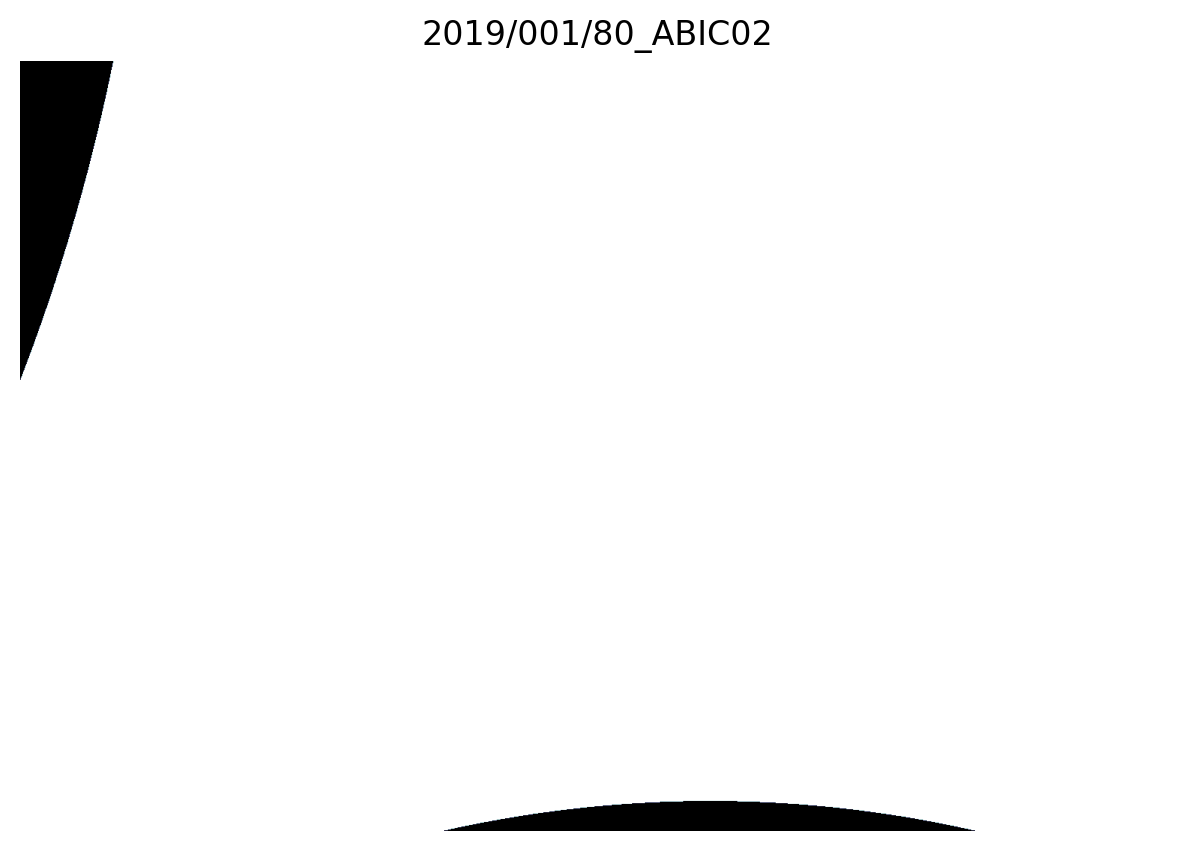

In [4]:
date = '2019/001'
num = '80'
var = 'ABIC02'
file = f'{num}_{var}.bin'
xdim = 1024
ydim = 1536

filename = os.path.join(VOL, date, file)
data = read_data(filename)
# data[data < 0] = np.nan

data = np.stack(data)
data -= np.nanmin(data)
data /= np.nanmax(data)
# TODO: use median of each channel as nan value
# data = np.nan_to_num(data, nan=0.0, copy=False)

shape = data.shape
xdiff = (shape[0] - xdim) // 2
ydiff = (shape[1] - ydim) // 2
data = data[xdiff:xdiff+xdim, ydiff:ydiff+ydim]

# TODO: use mean and std without nan
print(data.shape, data.dtype, np.nanmin(data), 
      np.nanmax(data), np.nanmean(data), np.nanstd(data))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(data, cmap='bone')
ax.set_title(f'{date}/{num}_{var}')
ax.axis('off')

plt.show()



(4, 1024, 1536) (1, 1024, 1536)


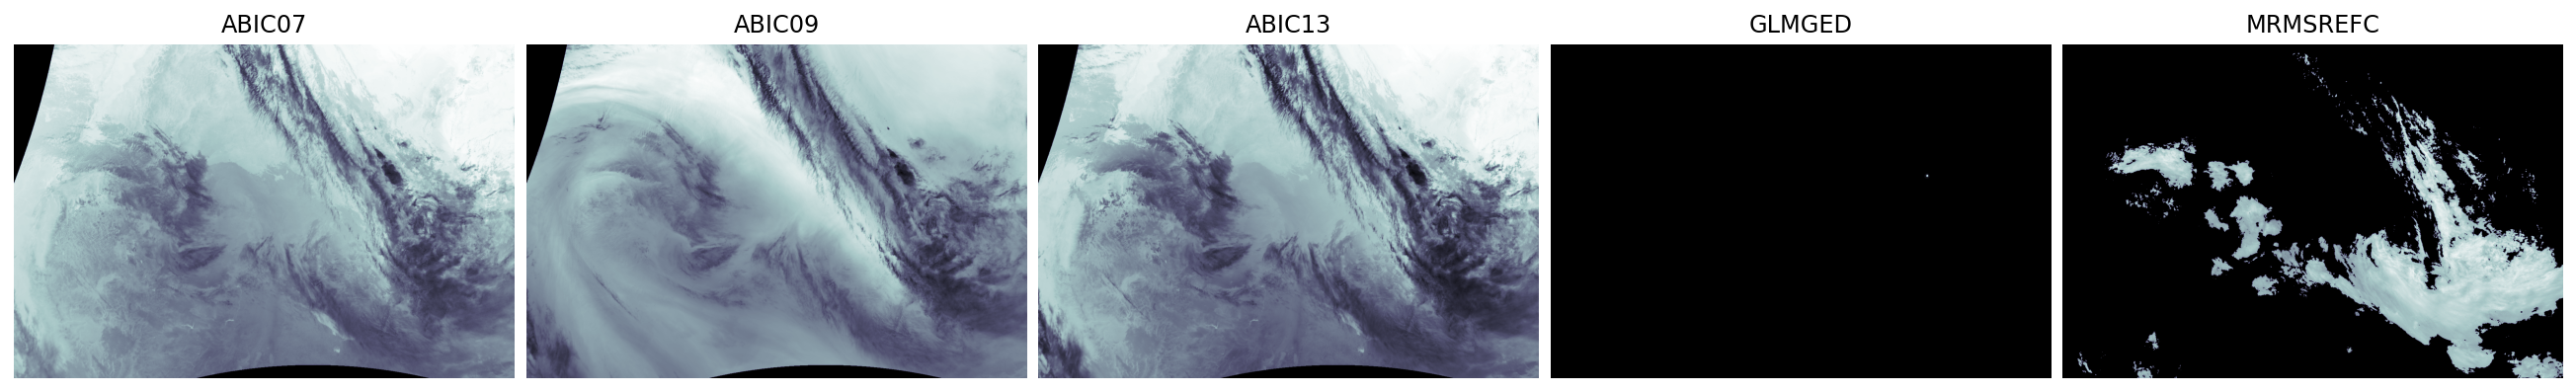

In [38]:
date = '2019/001'
num = '01'
xvars = ['ABIC07', 'ABIC09', 'ABIC13', 'GLMGED']
tvar = 'MRMSREFC'
xdim = 1024
ydim = 1536

x = []
for var in xvars:
    file = f'{num}_{var}.bin'
    filename = os.path.join(VOL, date, file)
    data = read_data(filename)
    data[data < 0] = np.nan
    x.append(data)
x = np.stack(x)
x -= np.nanmin(x, axis=(1,2), keepdims=True)
x /= np.nanmax(x, axis=(1,2), keepdims=True)
# TODO: use median of each channel as nan value
x = np.nan_to_num(x, nan=0.0, copy=False)

t = np.expand_dims(read_data(os.path.join(VOL, date, f'{num}_{tvar}.bin')), axis=0)
t[t==-999.0] = np.nan
t -= np.nanmin(t, axis=(1,2), keepdims=True)
t /= np.nanmax(t, axis=(1,2), keepdims=True)
t = np.nan_to_num(t, nan=0.0, copy=False)

shape = x.shape
xdiff = (shape[-2] - xdim) // 2
ydiff = (shape[-1] - ydim) // 2
x = x[:,xdiff:xdiff+xdim, ydiff:ydiff+ydim]
t = t[:,xdiff:xdiff+xdim, ydiff:ydiff+ydim]

print(x.shape, t.shape)

fig, axs = plt.subplots(1, 5, figsize=(18, 5), constrained_layout=True)
for i,ax in enumerate(axs):
    if i == len(axs)-1:
        data = t[0]
        title = f'{tvar}'
    else:
        data = x[i]
        title = f'{xvars[i]}'
    ax.imshow(data, cmap='bone')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [19]:
X, T = [], []
xvars = ['ABIC07', 'ABIC09', 'ABIC13', 'GLMGED']
tvar = 'MRMSREFC'

xdim = 1024
ydim = 1536
min_t, max_t = 0, 0
with open(os.path.join(VOL, 'good_samples.txt'), 'r') as f:
    for l in f:
        # NOTE: test for full dataset
        if '2019/001' not in l:
            continue

        l = l.rstrip().rpartition('/')
        date = l[0]
        num = l[2]
        
        x = []
        for var in xvars:
            file = f'{num}_{var}.bin'
            filename = os.path.join(VOL, date, file)
            data = read_data(filename)
            data[data < 0] = np.nan
            x.append(data)
            
        x = np.stack(x)
        x -= np.nanmin(x, axis=(1,2), keepdims=True)
        x /= np.nanmax(x, axis=(1,2), keepdims=True)
        # TODO: use median of each channel as nan value
        x = np.nan_to_num(x, nan=0.0, copy=False)

        t = np.expand_dims(read_data(os.path.join(VOL, date, f'{num}_{tvar}.bin')), axis=0)
        t[t==-999.0] = np.nan
        if np.nanmax(t) > max_t:
            max_t = np.nanmax(t)
        if np.nanmin(t) < min_t:
            min_t = np.nanmin(t)
        t -= np.nanmin(t, axis=(1,2), keepdims=True)
        t /= np.nanmax(t, axis=(1,2), keepdims=True)
        t = np.nan_to_num(t, nan=0.0, copy=False)

        shape = x.shape
        xdiff = (shape[-2] - xdim) // 2
        ydiff = (shape[-1] - ydim) // 2
        x = x[:,xdiff:xdiff+xdim, ydiff:ydiff+ydim]
        t = t[:,xdiff:xdiff+xdim, ydiff:ydiff+ydim]

        X.append(x)
        T.append(t)

X = np.stack(X)
T = np.stack(T)
print(X.shape, T.shape, min_t, max_t)


/tmp/ipykernel_3980009/2243318909.py:28: RuntimeWarning: invalid value encountered in divide
  x /= np.nanmax(x, axis=(1,2), keepdims=True)


(93, 4, 1024, 1536) (93, 1, 1024, 1536) -99.0 54.5


### Max Vals

In [11]:
from tqdm.notebook import tqdm

In [15]:
X, T = [], []
xvars = ['ABIC07', 'ABIC09', 'ABIC13', 'GLMGED']
tvar = 'MRMSREFC'

xdim = 1024
ydim = 1536

tmins = np.ones((1, 1, 1)) * np.inf
tmaxs = np.zeros((1, 1, 1))
xmins = np.ones((len(xvars), 1, 1)) * np.inf
xmaxs = np.zeros((len(xvars), 1, 1))

regex = r'^2019\/(0[0-3][0-9])'
pbar = tqdm()
with open(os.path.join(VOL, 'good_samples.txt'), 'r') as f:
    for l in f:
        if re.match(regex, l) is None:
            continue
        pbar.update(1)
        l = l.rstrip().rpartition('/')
        date = l[0]
        num = l[2]
        
        x = []
        for var in xvars:
            file = f'{num}_{var}.bin'
            filename = os.path.join(VOL, date, file)
            data = read_data(filename)
            data[data < 0] = np.nan
            x.append(data)
            
        x = np.stack(x)
        xmins = np.minimum(xmins, np.nanmin(x, axis=(1,2), keepdims=True))
        xmaxs = np.maximum(xmaxs, np.nanmax(x, axis=(1,2), keepdims=True))

        t = np.expand_dims(read_data(os.path.join(VOL, date, f'{num}_{tvar}.bin')), axis=0)
        t[t==-999.0] = np.nan
        tmins = np.minimum(tmins, np.nanmin(t, axis=(1,2), keepdims=True))
        tmaxs = np.maximum(tmaxs, np.nanmax(t, axis=(1,2), keepdims=True))

pbar.close()
print(f'{xmins=}\n{xmaxs=}\n{tmins=}\n{tmaxs=}')

0it [00:00, ?it/s]

xmins=array([[[197.30528259]],

       [[194.23445129]],

       [[194.2412262 ]],

       [[  0.        ]]])
xmaxs=array([[[385.55102539]],

       [[271.90548706]],

       [[314.81765747]],

       [[804.44445801]]])
tmins=array([[[-99.]]])
tmaxs=array([[[81.72222137]]])


81.72222137451172

In [ ]:
tnorm = (t - t.min()) / (t.max() - t.min())

In [18]:
print(X.shape, X.dtype, X.min(), X.max(), X.mean(), X.std())
print(T.shape, T.dtype, T.min(), T.max(), T.mean(), T.std())

(93, 4, 1024, 1536) float32 -1.2907362 1.0 -0.27631503 0.23263146
(93, 1, 1024, 1536) float32 0.0 0.60792077 0.04418727 0.13409305


In [15]:
print(X.shape, X.dtype, X.min(), X.max(), X.mean(), X.std())
print(T.shape, T.dtype, T.min(), T.max(), T.mean(), T.std())

(93, 4, 1024, 1536) float32 0.0 1.0 0.42972398 0.3083897
(93, 1, 1024, 1536) float32 0.0 1.0 0.07421955 0.2252385


In [43]:
smalldata = os.path.join(VOL, 'smalldata.npz')
# np.savez(smalldata, X=X, T=T)

# npzfile = np.load(smalldata)
# X = npzfile['X']
# T = npzfile['T']

### Plotting

In [49]:
def get_data(filename):
    loss, met = [], [] # assumes (train, val) dims
    with open(filename) as fi:
        for ln in fi:
            if ln.startswith('train loss'):
                ln = ln.rstrip()
                loss.append(re.findall(r'loss: (\d+\.\d+)', ln))
                met.append(re.findall(r'met: (\d+\.\d+)', ln))

    loss = np.stack(loss).astype(float)
    met = np.stack(met).astype(float)
    return loss, met

In [50]:
model_name = 'vit'
media_path = os.path.join('../media', model_name)
if not os.path.exists(media_path):
    os.makedirs(media_path)
loss, met = get_data(f'../logs/{model_name}.out')

ValueError: need at least one array to stack

In [ ]:
cmap = cm.get_cmap('Spectral', 8)

fontsize = 11
lw = 2
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(met[:,0], label='train', ls='-', lw=lw,
        color=cmap(6))
ax.plot(met[:,1], label='val', ls='-', lw=lw, 
        color=cmap(1))
min_x = np.argmin(met[:,1])
min_y = met[min_x,1]
ax.plot(min_x, min_y, 'x', color='black', ms=10, mew=2.5, label=f'{min_y:.2f}')
ax.set_xlabel('Epoch', fontsize=fontsize)
ax.set_ylabel('RMSE (dBZ)', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(alpha=0.5)
# fig.savefig(os.path.join(media_path, f'loss.png'), dpi=300, bbox_inches='tight')

In [53]:
Xtrain, Ttrain, Xtest, Ttest = dataloader._gremlin(VOL)
# Ytest = np.load(os.path.join(vol, model_name, 'test_predictions.npy'))
# X, T, Y = Xtest, Ttest, Ytest

Ytrain = np.load(os.path.join(VOL, 'out', model_name, f'test_predictions.npy'))
X, T, Y = Xtrain, Ttrain, Ytrain

print(X.min(), X.max(), T.min(), T.max(), Y.min(), Y.max())
X.shape, T.shape, Y.shape

0.0 1.0 0.0 1.0 -0.170896 0.9185671


((74, 4, 1024, 1536), (74, 1, 1024, 1536), (19, 1, 1024, 1536))

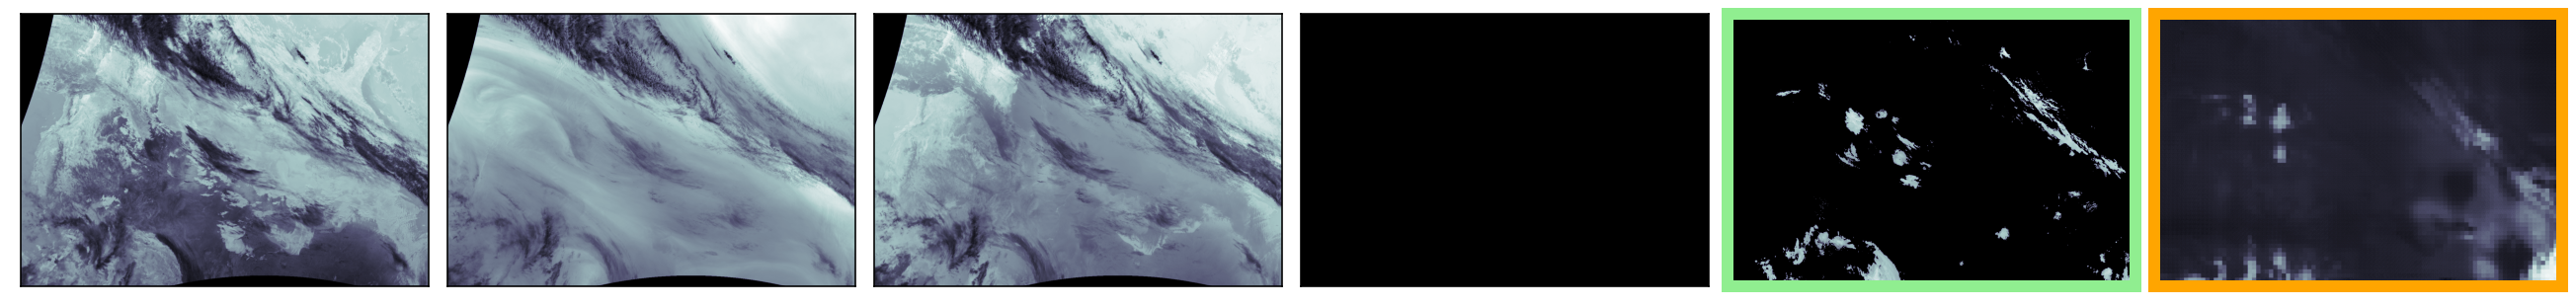

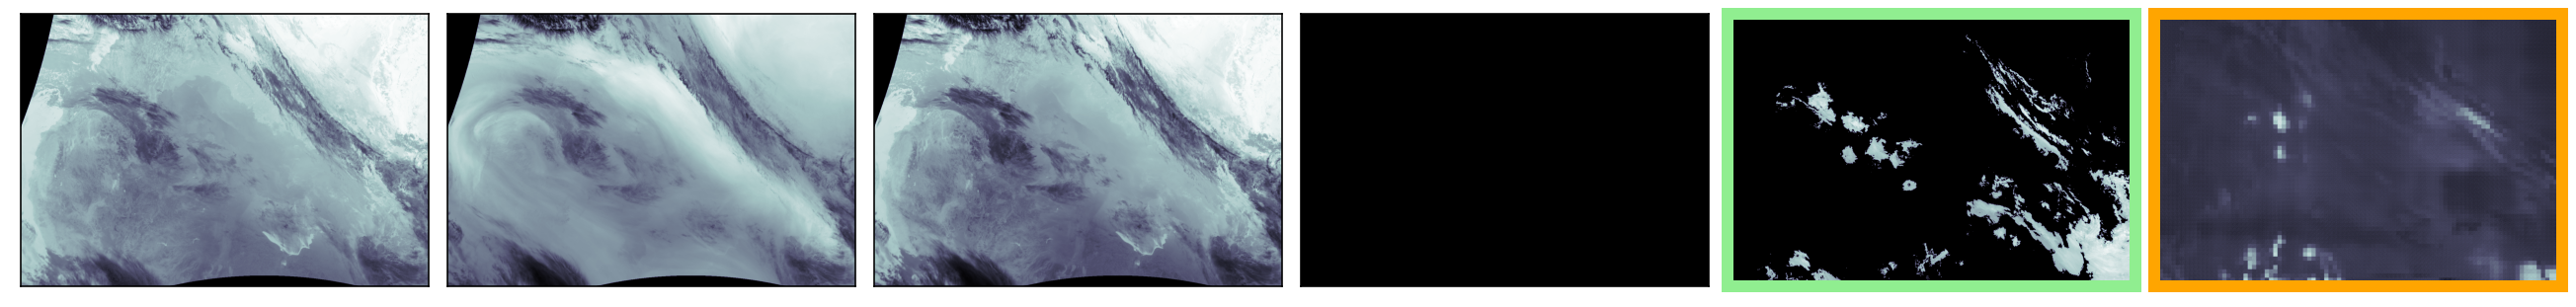

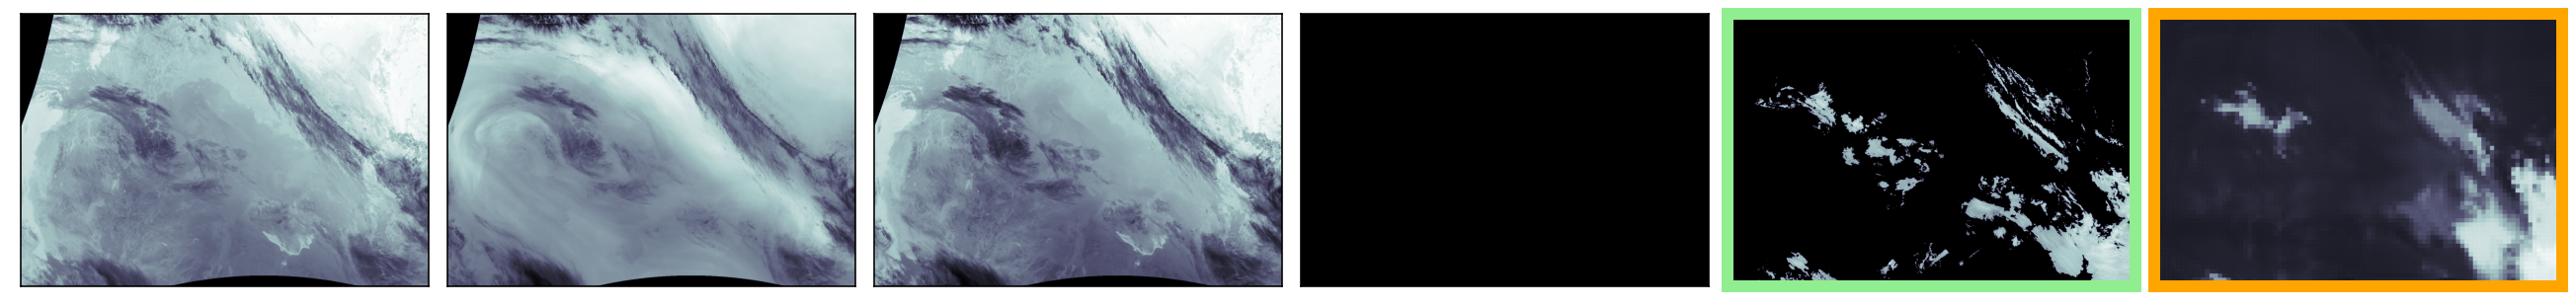

In [56]:
for s in [0, 5, 10]:
    fig, axs = plt.subplots(1, 6, figsize=(18, 6), sharey=True, constrained_layout=True)
    for i, ax in enumerate(axs[:4]):
        ax.imshow(X[s,i], cmap='bone')

    axs[-2].imshow(T[s,0], cmap='bone')
    axs[-1].imshow(Y[s,0], cmap='bone')

    for spine in axs[-2].spines.values():
        spine.set_edgecolor('lightgreen')
        spine.set_linewidth(6)

    for spine in axs[-1].spines.values():
        spine.set_edgecolor('orange')
        spine.set_linewidth(6)

    for ax in axs:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

    # fig.savefig(os.path.join(media_path, f'{s}.png'), dpi=300, bbox_inches='tight')